In [66]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import sqlite3 as sl
from sklearn.preprocessing import MinMaxScaler

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style("white")



Loading season 13 data from database

In [55]:
con = sl.connect(r'C:\CODE\learning\Apex_cluster\database\apex.db')
df = pd.read_sql("select * from api_rank_s13",con)

Basic Cleaning

In [56]:
# drop nans for kills and zeros
df = df.dropna(subset=['kills', 'level'])
df = df[df['kills'] != 0]

# drop players in rookie rank
df = df[df['rank'] != 'Rookie']
print(len(df))

1121


In [57]:
# missing values by column
df.isnull().sum()

uid                 0
username            0
level               0
rankscore           0
rank                0
skin                0
skinrarity          0
kd                  0
kills               0
damage            406
top_3            1007
games_played      917
date_accessed       0
dtype: int64

Overall rank distribution of sample

<AxesSubplot:xlabel='rank', ylabel='Count'>

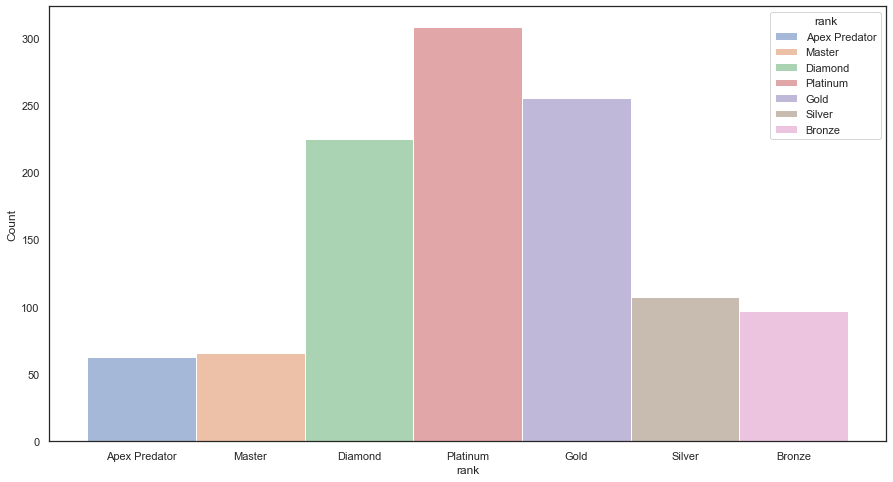

In [67]:
df = df.sort_values(by=['rankscore'], ascending=False)
sns.histplot(data=df, x="rank", hue="rank", binwidth=10)

Overall skinrarity of sample

<AxesSubplot:xlabel='skinrarity', ylabel='Count'>

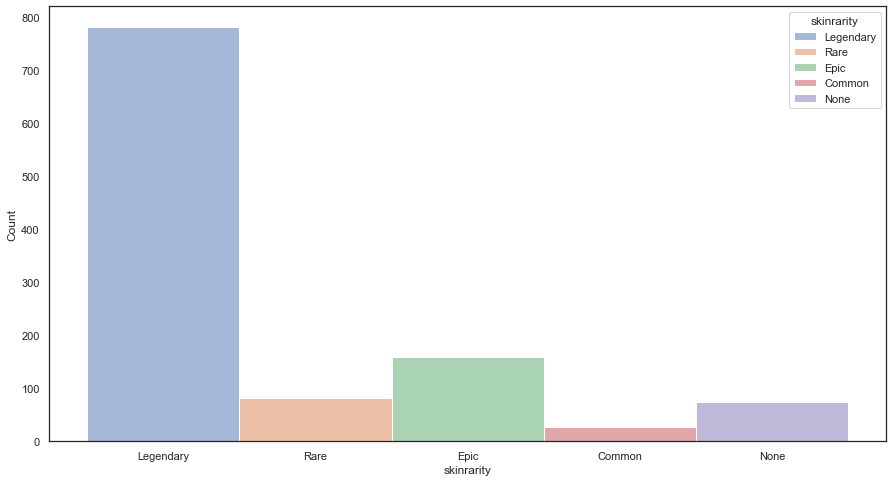

In [68]:
sns.histplot(data=df, x="skinrarity", hue='skinrarity', binwidth=10)

Kills and level (unviariate) by rank, both left skewed especially in lower more populated ranks

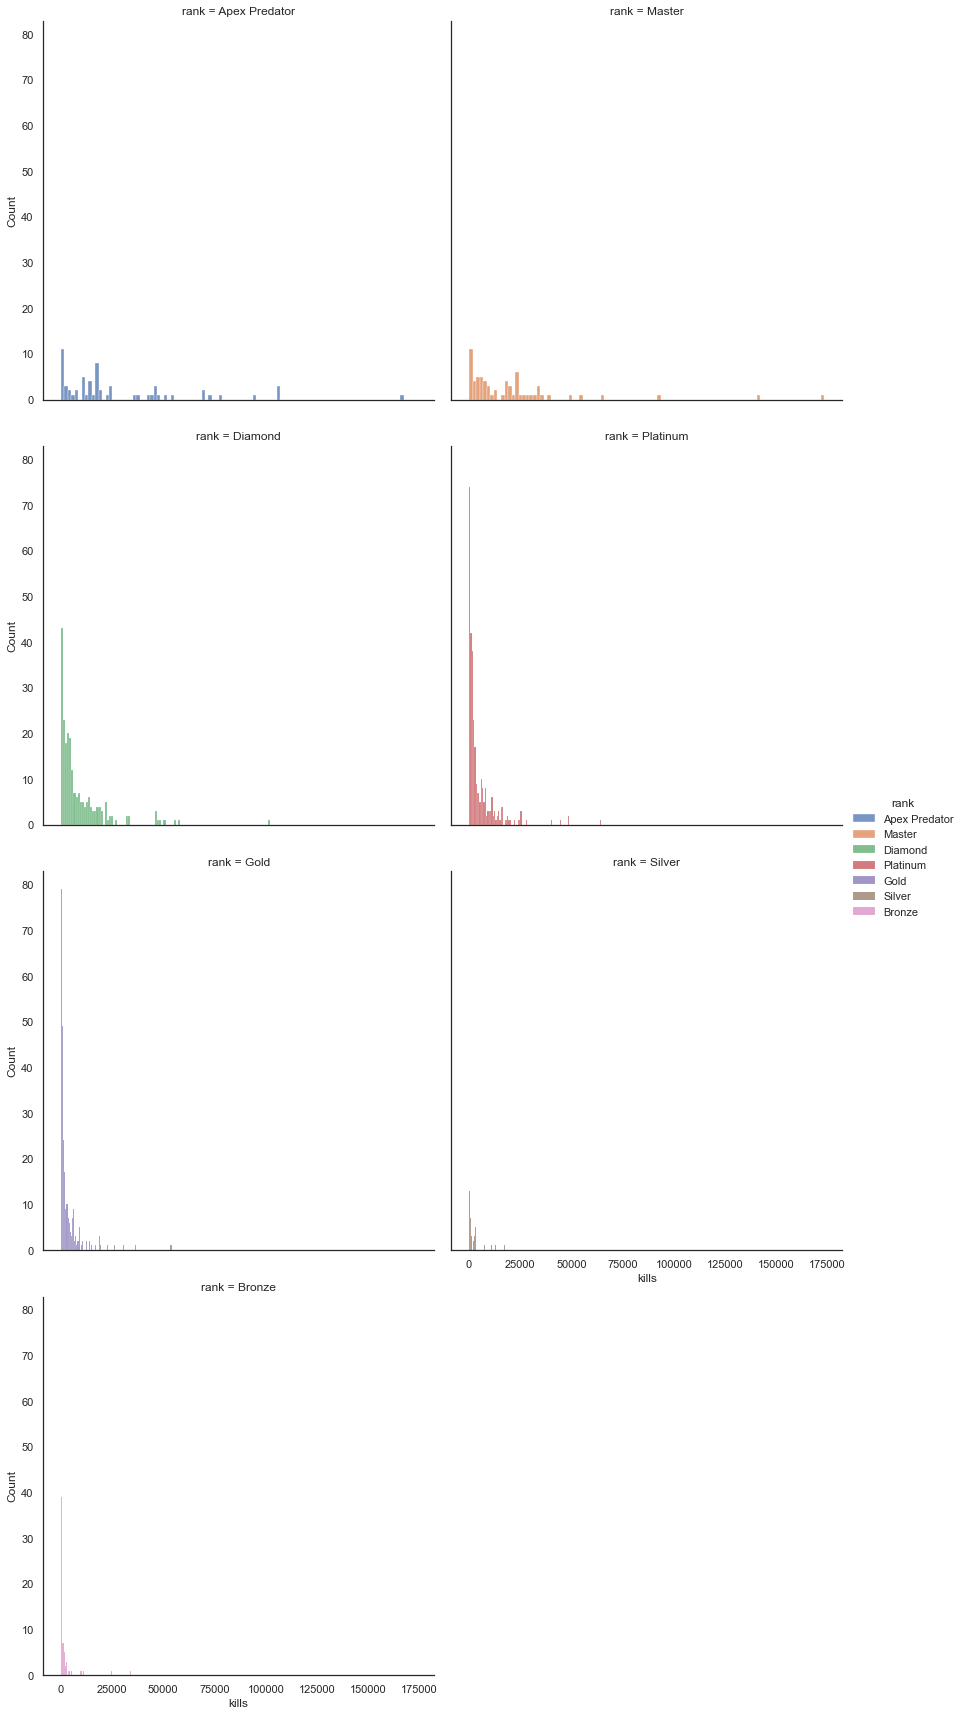

In [69]:
g = sns.FacetGrid(df, col="rank", hue="rank", col_wrap=2, size=6)
g.map_dataframe(sns.histplot,  x ='kills', bins=100)
g.add_legend()

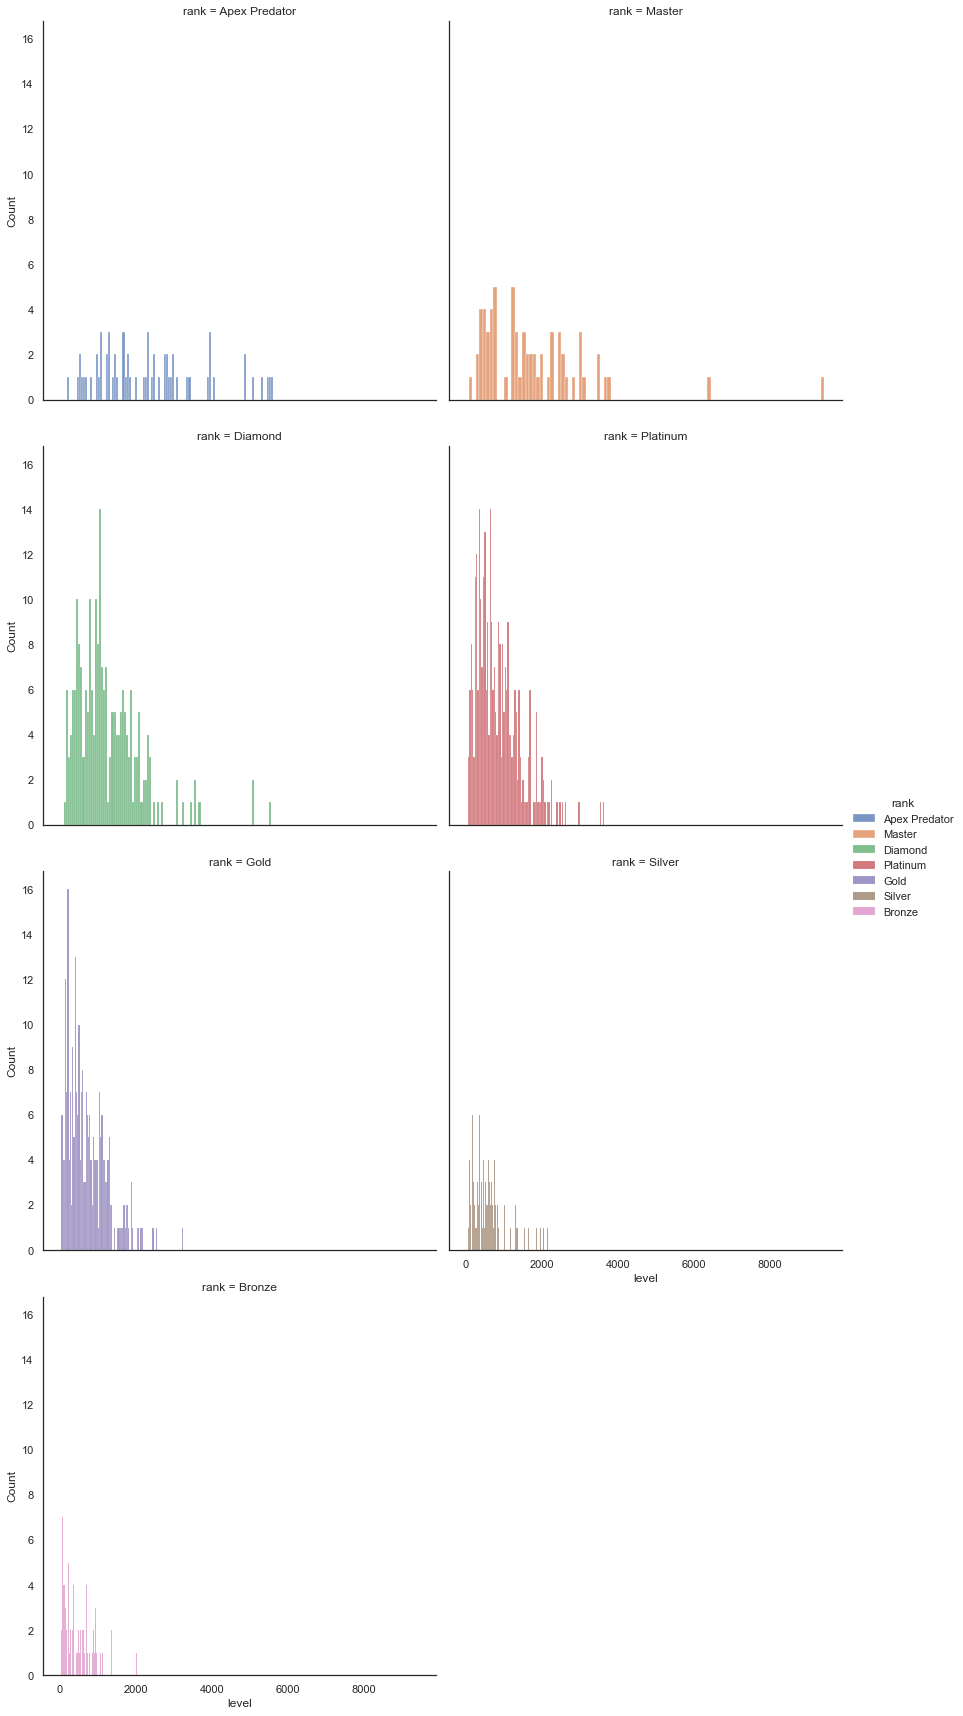

In [70]:
g = sns.FacetGrid(df, col="rank", hue="rank", col_wrap=2, size=6)
g.map_dataframe(sns.histplot,  x ='level', bins=100)
g.add_legend()

<AxesSubplot:xlabel='kills', ylabel='rank'>

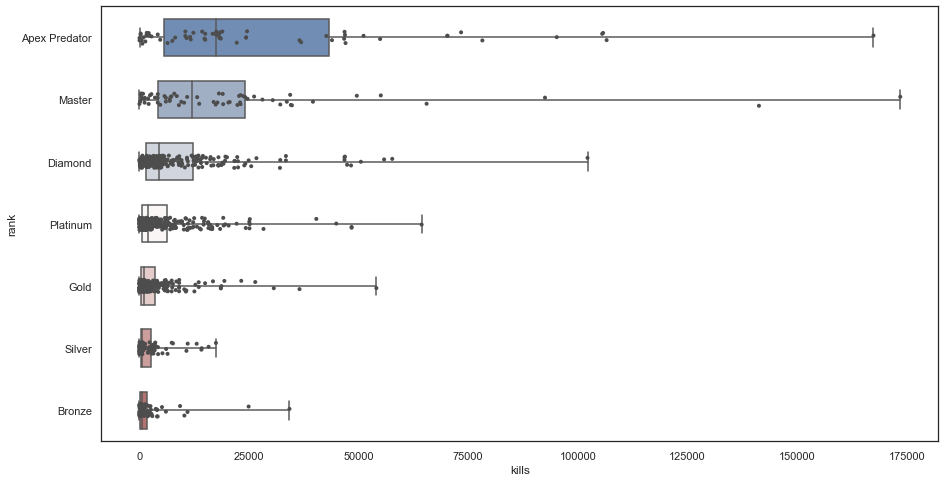

In [71]:
sns.boxplot(x="kills", y="rank", data=df,
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="kills", y="rank", data=df,
              size=4, color=".3", linewidth=0)

<AxesSubplot:xlabel='level', ylabel='rank'>

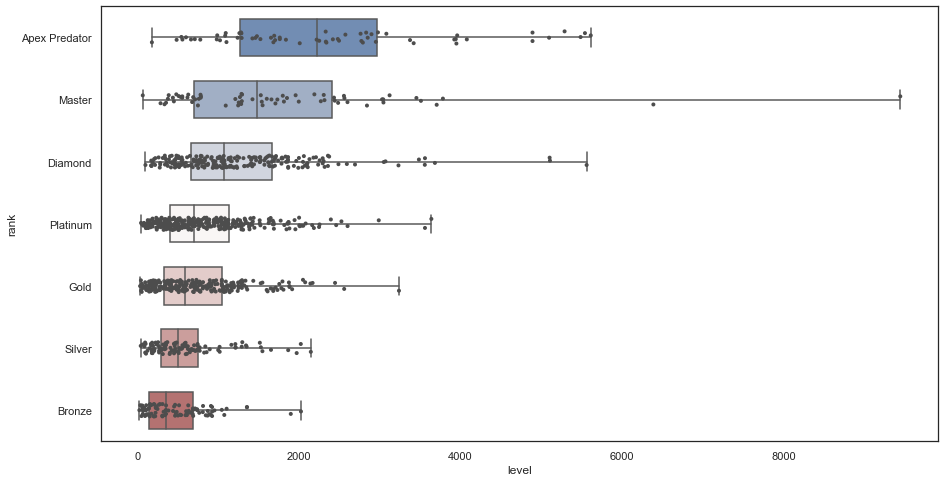

In [72]:
sns.boxplot(x="level", y="rank", data=df,
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="level", y="rank", data=df,
              size=4, color=".3", linewidth=0)

Kills/level bivariate plot by rank

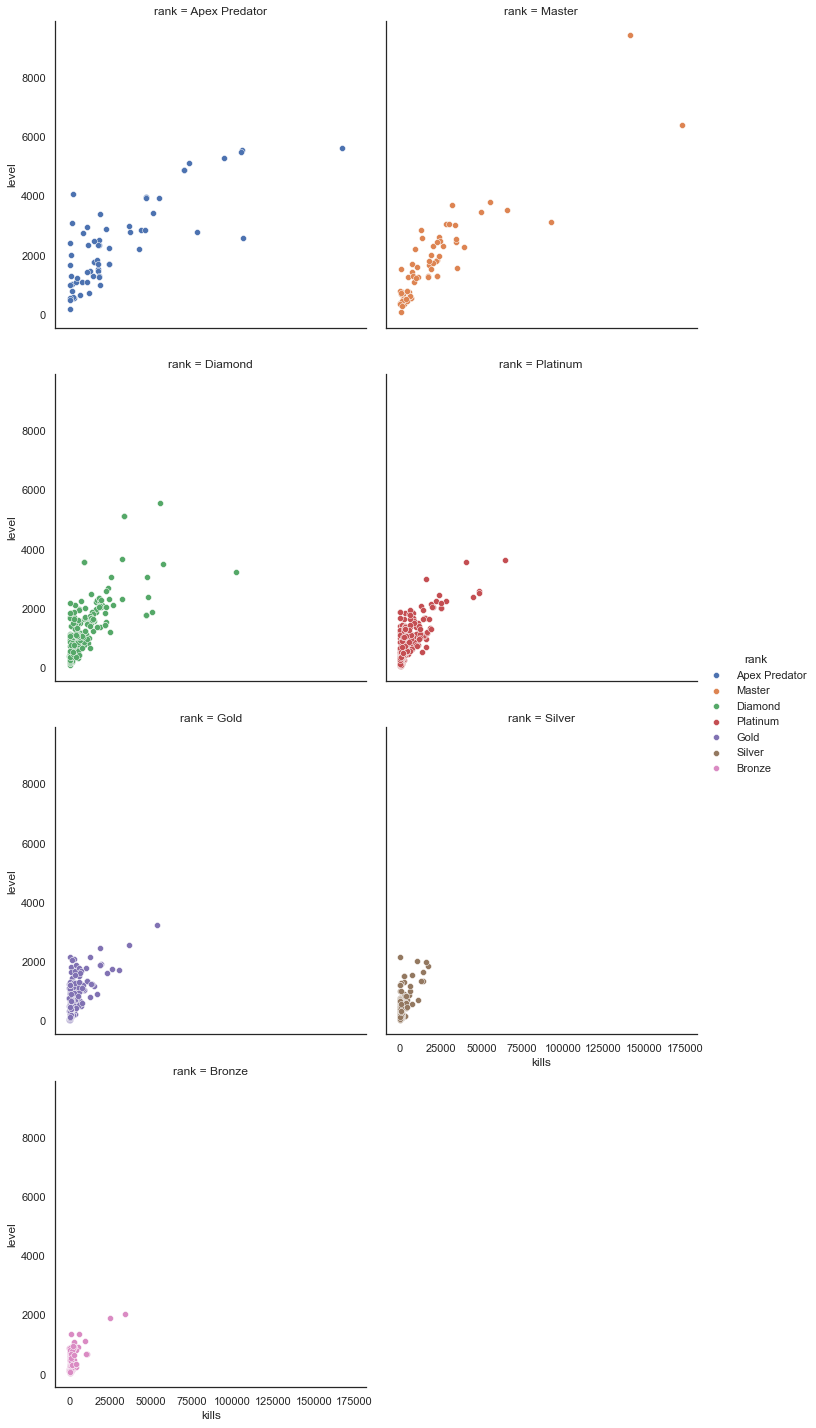

In [73]:
g = sns.FacetGrid(df, col="rank", hue="rank", col_wrap=2, size=5)
g.map_dataframe(sns.scatterplot, x="kills", y="level")
g.add_legend()

Log transforming/Scaling (min/max) kills and level to put both variables on the same scale and remove skewness

NormaltestResult(statistic=65.60353303791473, pvalue=5.680333103258099e-15)


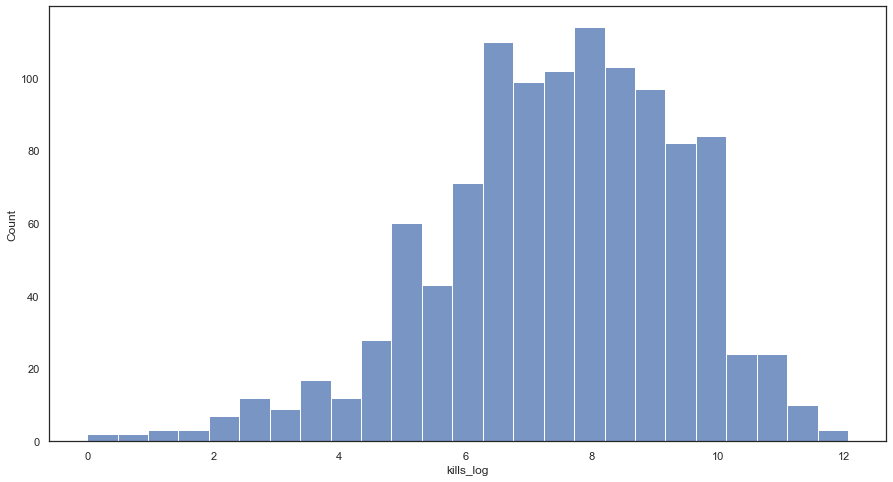

In [74]:
df['kills_log'] = np.log(df['kills'])
sns.histplot(data = df, x ='kills_log')
print(stats.normaltest(df['kills_log']))

NormaltestResult(statistic=47.415677355672926, pvalue=5.056109656998741e-11)


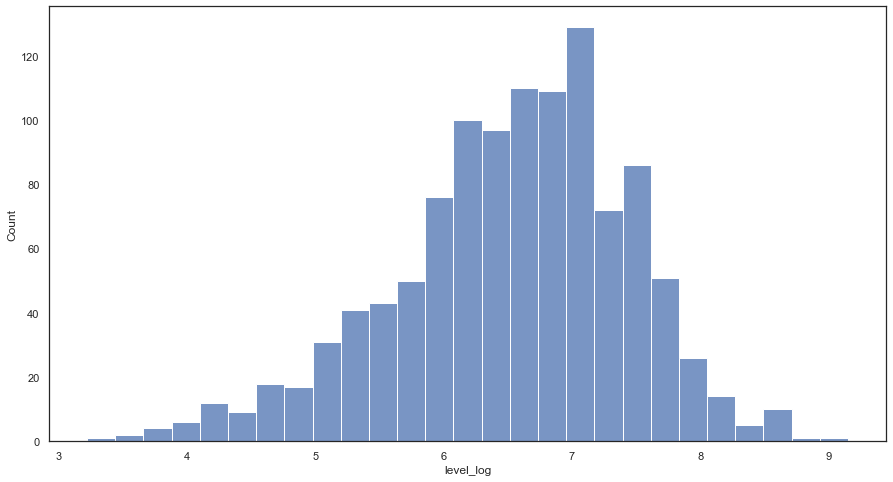

In [75]:
df['level_log'] = np.log(df['level'])
sns.histplot(data = df, x ='level_log')
print(stats.normaltest(df['level_log']))

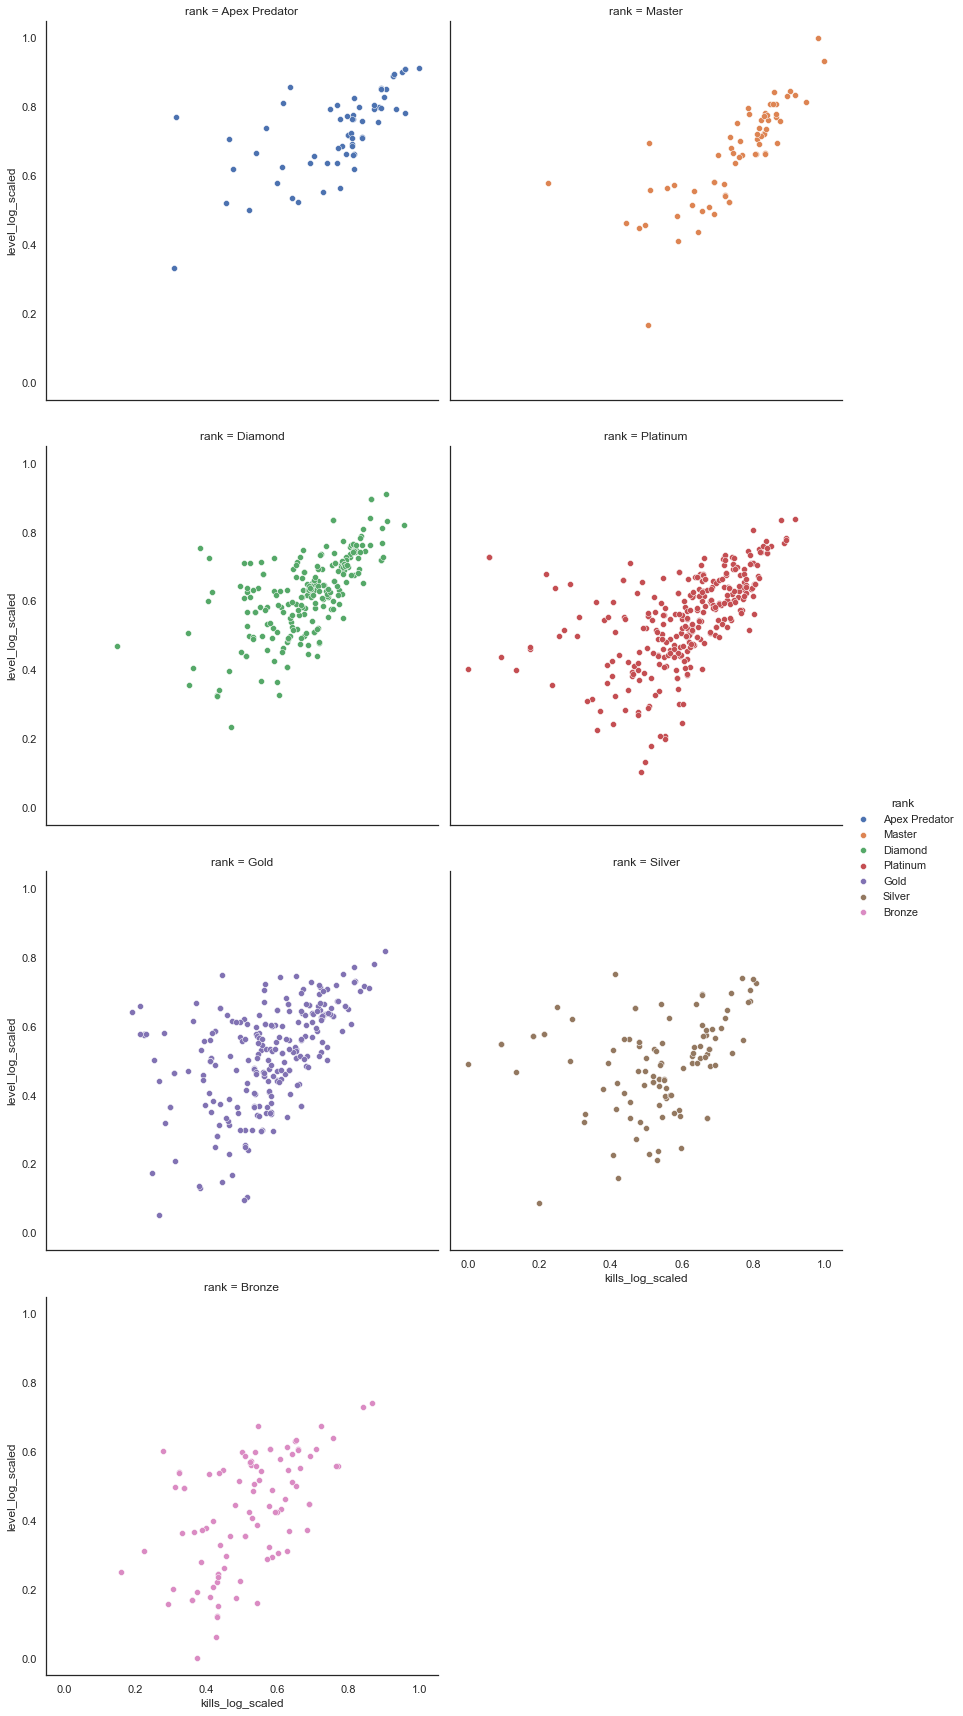

In [76]:
scaler = MinMaxScaler()
df['kills_scaled'] = scaler.fit_transform(df[['kills']])
df['level_scaled'] = scaler.fit_transform(df[['level']])
df['level_log_scaled'] = scaler.fit_transform(df[['level_log']])
df['kills_log_scaled'] = scaler.fit_transform(df[['kills_log']])


g = sns.FacetGrid(df, col="rank", hue="rank", col_wrap=2, size=6)
g.map_dataframe(sns.scatterplot, x="kills_log_scaled", y="level_log_scaled")
g.add_legend()

Creating variable by dividing kills by level

In [77]:
df['kill_per_level'] = df['kills']/df['level']
averages = df.groupby('rank')['kill_per_level'].median()
print(averages)

rank
Apex Predator    9.648574
Bronze           1.930556
Diamond          4.547315
Gold             2.792793
Master           9.161366
Platinum         3.441084
Silver           2.153409
Name: kill_per_level, dtype: float64


<AxesSubplot:xlabel='kill_per_level', ylabel='rank'>

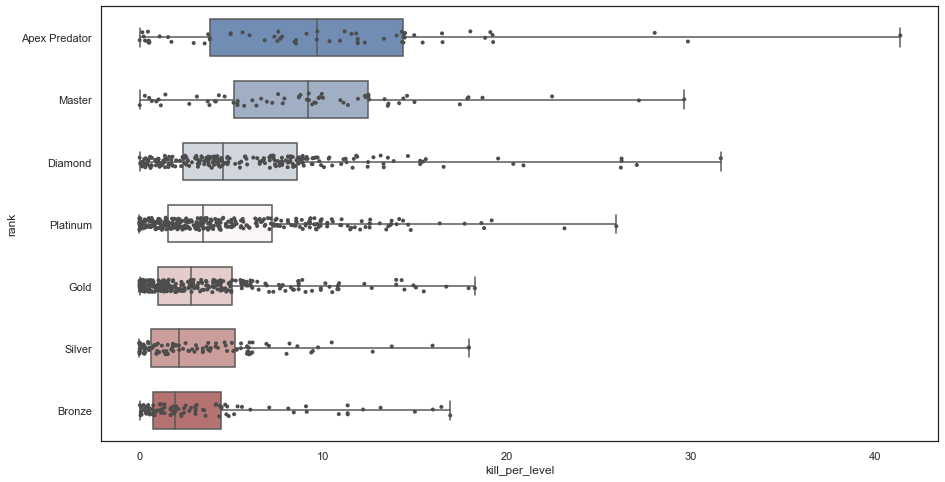

In [78]:
sns.boxplot(x="kill_per_level", y="rank", data=df,
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="kill_per_level", y="rank", data=df,
              size=4, color=".3", linewidth=0)

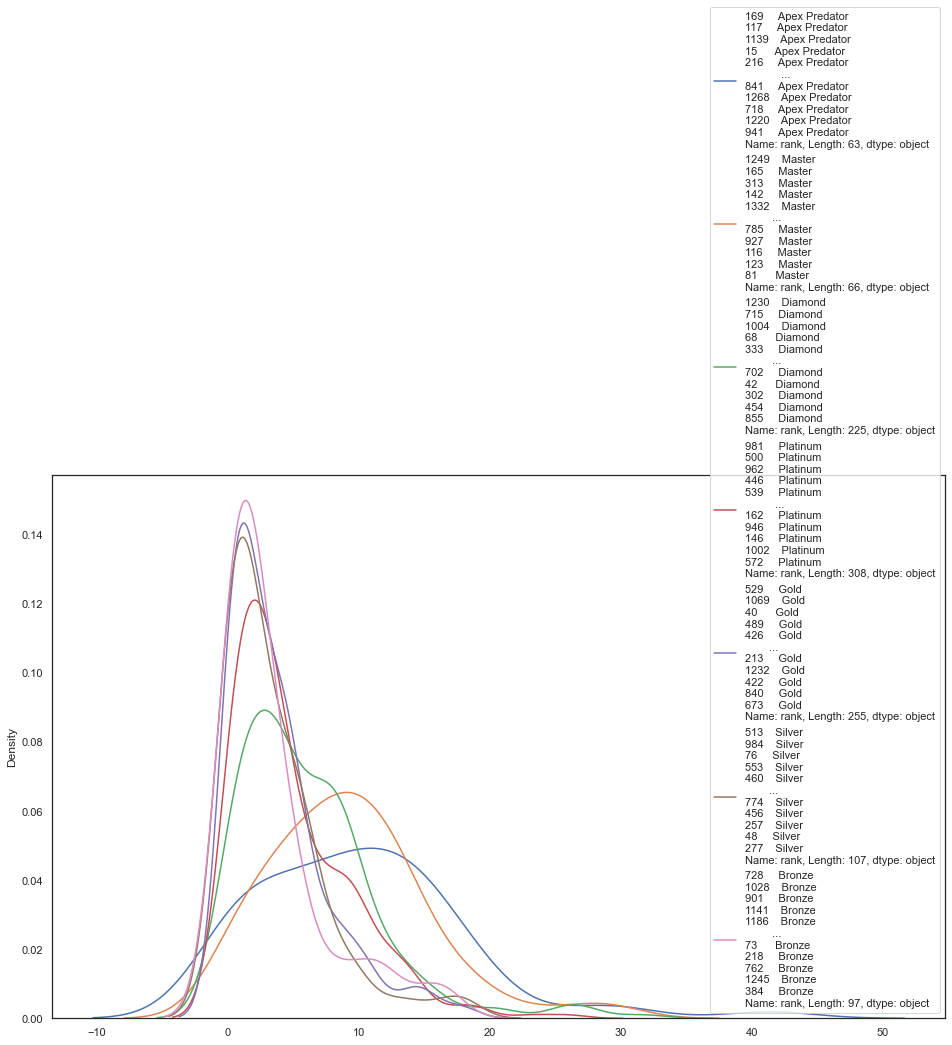

In [79]:
unique_vals = df['rank'].unique()  # [0, 1, 2]

# Sort the dataframe by target
# Use a list comprehension to create list of sliced dataframes
targets = [df.loc[df['rank'] == val] for val in unique_vals]

# Iterate through list and plot the sliced dataframe
for target in targets:
    sns.distplot(target[['kill_per_level']], hist=False, label=target['rank'])

fig = plt.gcf()
fig.set_size_inches (16, 10)
plt.legend()

Skin rarity by rank

array([<AxesSubplot:ylabel='Apex Predator'>,
       <AxesSubplot:ylabel='Bronze'>, <AxesSubplot:ylabel='Diamond'>,
       <AxesSubplot:ylabel='Gold'>, <AxesSubplot:ylabel='Master'>,
       <AxesSubplot:ylabel='Platinum'>, <AxesSubplot:ylabel='Silver'>],
      dtype=object)

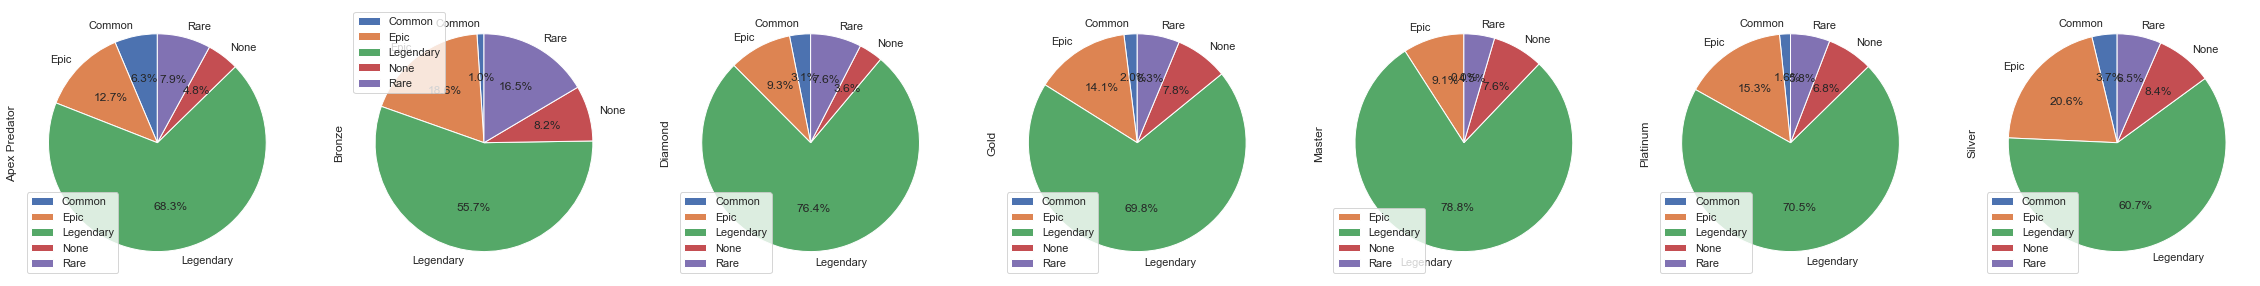

In [80]:
df.groupby(['skinrarity', 'rank']).size().unstack().plot(kind='pie',subplots=True, figsize=(40, 40), autopct='%1.1f%%', startangle=90)